In [3]:
import csv
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

## Reading in the Data

In [6]:
path_f=os.getcwd()

path_f_1=os.path.join(path_f, 'data')


names=[]
for files_txts in os.listdir(path_f_1):
    if files_txts.endswith(".csv"):
        #print(files_txts)
        names.append(files_txts)
        
path_train=os.path.join(path_f_1, names[0])
path_test=os.path.join(path_f_1, names[1])

In [7]:
csvfile = csv.reader(open(path_train,'r'))
header = next(csvfile)

### Feature Engineering and Data Formatting

In [9]:
data = []
formulaA = []
formulaB = []
stabilityVec = []
for row in csvfile:
    formulaA.append(row[0])
    formulaB.append(row[1])
    data.append(np.array([np.float(x) for x in row[2:-1]]))
    stabilityVec.append(np.array([np.float(x) for x in row[-1][1:-1].split(',')]))

stabilityVec = np.array(stabilityVec)

formulas = formulaA + formulaB
formulas = list(set(formulas))

Transforming the formula to and integer and saving it as a dictionary

In [28]:
formula2int = {}
int2formula = {}
for i, f in enumerate(formulas):
    formula2int[f] = i
    int2formula[i] = f

In [29]:
formulaAint = np.array([formula2int[x] for x in formulaA])
formulaBint = np.array([formula2int[x] for x in formulaB])

In [31]:
data = np.array(data)
data = np.concatenate((formulaAint[:,None], formulaBint[:,None], data), axis=1)

In [34]:
data.shape

(2572, 98)

#### Normalizing the data

In [54]:
data = normalize(data, axis=1)
print(data.shape)

(2572, 98)


## Performing PCA

In [98]:
pca = PCA()
pca.fit(data)

explained_var = pca.explained_variance_
print('top 10 explained variance: ', explained_var[:10])

components = pca.components_[:10,:]

top 10 explained variance:  [0.09584018 0.08452783 0.05184509 0.04871557 0.03646006 0.01696581
 0.01548128 0.00906685 0.00633603 0.00195537]


### Visualizing PCA

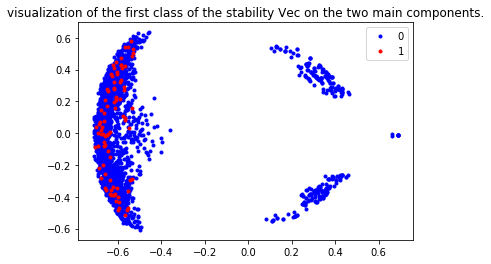

In [99]:
new_data = np.dot(data, components.T)
cl = 2
indexes_0 = stabilityVec[:,2]==0.0
indexes_1 = stabilityVec[:,2]==1.0
plt.plot(new_data[indexes_0,0], new_data[indexes_0,1], 'b.', linestyle='', label='0')
plt.plot(new_data[indexes_1,0], new_data[indexes_1,1], 'r.', linestyle='', label='1')
plt.title('visualization of the first class of the stability Vec on the two main components.')
plt.legend()

In [100]:
new_data = np.dot(data, components.T)
print(new_data.shape)


(2572, 10)


## Notice how each of the compunds is always a stable output of the reaction
    There is no need for a model these values then
    We only need to predict the compounds that for from 10% to 90%

In [101]:
for i in range(9):
    print('class ', i, '  ', np.histogram(stabilityVec[:,i+1], bins=2))

class  0    (array([2522,   50]), array([0. , 0.5, 1. ]))
class  1    (array([2484,   88]), array([0. , 0.5, 1. ]))
class  2    (array([1974,  598]), array([0. , 0.5, 1. ]))
class  3    (array([2396,  176]), array([0. , 0.5, 1. ]))
class  4    (array([1988,  584]), array([0. , 0.5, 1. ]))
class  5    (array([2387,  185]), array([0. , 0.5, 1. ]))
class  6    (array([2212,  360]), array([0. , 0.5, 1. ]))
class  7    (array([2180,  392]), array([0. , 0.5, 1. ]))
class  8    (array([2512,   60]), array([0. , 0.5, 1. ]))


# Multi-label classification problem


In [102]:
y_true = stabilityVec[:,1:-1]
X_train, X_test, y_train, y_test = train_test_split(new_data, y_true,
                                                    test_size=0.33,
                                                    shuffle=True,
                                                    random_state=42)

## KNN Classifier test

In [103]:
print(' -- KNN --')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
F1 = f1_score(y_test, y_pred, average='micro')

accuracy = np.mean((y_test == y_pred).all(axis=1))

print('precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)

 -- KNN --
precision:  0.5461165048543689   recall:  0.27743526510480887   F1:  0.3679476696647588   accuracy:  0.5265017667844523


## Random Forest Test

In [104]:
print(' -- Random Forest --')
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
F1 = f1_score(y_test, y_pred, average='micro')

accuracy = np.mean((y_test == y_pred).all(axis=1))

print('precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)

 -- Random Forest --
precision:  0.8076923076923077   recall:  0.025893958076448828   F1:  0.05017921146953405   accuracy:  0.5335689045936396


In [105]:
y_test[12]

array([0., 1., 1., 0., 0., 0., 0., 0., 0.])

In [106]:
y_pred[12]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])